In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_15192\4031092812.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### ALL FUNCTIONS

In [3]:
def wave_peaks_tdf(df,r):
    df_plt = df.isel(row = r)
    plt.figure()
    plt.title('Data')
    plt.plot(df_plt.time, df_plt.I_1356, 'C3.-') 
    plt.show()
    
    from scipy.signal import find_peaks
    data = df.I_1356.isel(row = r)
    data_np = data.to_numpy()
    np.shape(data)
    
    max_data = max(data_np)
    time_diff = datetime.timedelta(minutes=19, hours=1) 

    
    indices = find_peaks(data, height = max_data * (4/6), distance = 100) 
    
    indexes = indices[0]
    #print(indexes)
    final_indexes = []
    
    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    #print(final_indexes)
    
    times_np = df_plt.time.to_numpy()
    
    times = []
    vals_at_times = []

    return vals_at_times
  

In [4]:
def orbits_finder(df):
    #r = 148
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [5]:
def single_orb(orbit_arr,n):
    orb = orbit_arr[n].mean(dim = 'row')
    t = orb.time
    val = orb.I_1356
    return(t, val)

In [6]:
def swp_data_opening_w_stripe(stripe,d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')
    dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_PROF_'+str(stripe)]]
    # Convert times to something Python and xarray can understand, and reindex the dataset by time instead of the obscure "Epoch"
    t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
    dsf['time'] = (['Epoch'], t)
    dsf = dsf.swap_dims({'Epoch':'time'})
    dsf = dsf.rename({'Rows':'row'})
    # Rename and drop useless variables
    dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_PROF_'+str(stripe)]
    dsf = dsf.drop(['ICON_L1_FUVA_SWP_PROF_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    return dsf

In [7]:
def lwp_data_opening_w_stripe(stripe,d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')
    dsf_raw
    dsf = dsf_raw[['ICON_L1_FUVB_LWP_Center_Times','ICON_L1_FUVB_LWP_PROF_'+str(stripe)]]
    # Convert times to something Python and xarray can understand, and reindex the dataset by time instead of the obscure "Epoch"
    t = pd.to_datetime(dsf.ICON_L1_FUVB_LWP_Center_Times.values)
    dsf['time'] = (['Epoch'], t)
    dsf = dsf.swap_dims({'Epoch':'time'})
    dsf = dsf.rename({'Rows':'row'})
    #  Rename and drop useless variables
    dsf['I_1356'] = dsf['ICON_L1_FUVB_LWP_PROF_'+str(stripe)]
    dsf = dsf.drop(['ICON_L1_FUVB_LWP_PROF_'+str(stripe),'ICON_L1_FUVB_LWP_Center_Times','Epoch'])
    return dsf

In [22]:
def correlations(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])
   
    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)
    
    s_lim = int(1.5 * lim_val)

    time_start = v1['time'].isel(time=s_lim).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)
    
    plt.figure()
    plt.title("Original Signals")
    plt.plot(t_interp*1e-9,v1_interp,'b',label = str(label1))
    plt.plot(t_interp*1e-9,v2_interp,'r', label = str(label2))
    plt.legend()
    plt.show()


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp))) # CHANGED FROM t_vals TO t_interp
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) 
    print('index',max_index)
    
    # Calculate difference from 0
    max_difference = taus_shifted[max_index] - 0
    print('xval',taus_shifted[max_index])
    print("Difference from 0:", max_difference*1e-9)
    #print()

    # PLOT
    plt.figure()
    plt.plot(taus_shifted, V12_shifted, '.-r')
    plt.plot(taus_shifted[max_index], V12_shifted[max_index], 'bo', markersize=4)  
    plt.title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    plt.ylabel('Correlated Power')
    #plt.xlabel('Time [ns]')
    #plt.xlim(-100, 100)
    plt.axvline(0)
    plt.grid()
    plt.show()


In [21]:
def corr_fuvs_and_fuvs(orbit1_data, orbit2_data, label1, label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)


    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    s = len(orbit1_data["I_1356_filt"])
    lim_val = int(s/6)
    
    s_lim = int(1.5 * lim_val)

    time_start = orbit1_data['time'].isel(time=s_lim).values
    time_end =  orbit1_data['time'].isel(time=lim_val * 5).values

    orbit1_data = orbit1_data.sel(time=slice(time_start, time_end))
    orbit2_data = orbit2_data.sel(time=slice(time_start, time_end))

    (fig, (ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize = (10,15))

    # FUV 1
    vm = abs(orbit1_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_1 = ax1.pcolormesh(pd.to_datetime(orbit1_data.time.values), orbit1_data.row, orbit1_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax1.set_ylabel('row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title('FUV 1356 brightness of Stripe %s' %(label1))

    # FUV 2
    vm = abs(orbit2_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_2 = ax2.pcolormesh(pd.to_datetime(orbit2_data.time.values), orbit2_data.row, orbit2_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax2.set_ylabel('row')
    #ax2.colorbar(label='R')
    fig.colorbar(pcm_2, ax = ax2, label='R')
    ax2.set_title('FUV 1356 brightness of Stripe %s' %(label2))


    plt.tight_layout()

    
    # CORR

    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')
    
    SIZE = len(v1["I_1356_filt"])

    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)

    s_lim = int(1.5 * lim_val)

    time_start = v1['time'].isel(time=s_lim).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)
    

    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp))) 
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)

    ax3.plot(taus_shifted, V12_shifted, '.-r')
    ax3.set_title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    ax3.set_ylabel('Correlated Power')
    ax3.axvline(0)
    ax3.grid()
    plt.show()

In [34]:
def differences(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])

    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)
    
    s_lim = int(lim_val * 1.5)

    time_start = v1['time'].isel(time=s_lim).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)
    
    #print('CORRELATION OF:',label1,label2)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) 
    #print('Index:',max_index)
    
    # Calculate difference from 0
    max_difference = (taus_shifted[max_index] - 0)*1e-9

    return label1,label2,max_difference


In [35]:
def angle_diff(all_orbs,all_labels):
    first = []
    second = []
    diffs = []

    for orbit1_idx in range(0,len(all_orbs)):
        for orbit2_idx in range(0,len(all_orbs)):
            diff = differences(all_orbs[orbit1_idx],all_orbs[orbit2_idx],all_labels[orbit1_idx],all_labels[orbit2_idx])
            first.append(diff[0])
            second.append(diff[1])
            diffs.append(diff[2])
            
    # DF CREATION
    d = {'First': first,'Second':second,'Difference':diffs}

    angle_offsets = pd.DataFrame(data=d)

    # FIRST
    angle_offsets['First Angle'] = angle_offsets['First'].str.extract('(\d+)').astype(int)
    angle_offsets['First Angle'] = angle_offsets.apply(
        lambda row: -row['First Angle'] if row['First'].startswith('M') else row['First Angle'], axis=1
    )

    # SECOND

    angle_offsets['Second Angle'] = angle_offsets['Second'].str.extract('(\d+)').astype(int)
    angle_offsets['Second Angle'] = angle_offsets.apply(
        lambda row: -row['Second Angle'] if row['Second'].startswith('M') else row['Second Angle'], axis=1
    )


    angle_offsets['Angle Diff'] = (angle_offsets['Second Angle']- angle_offsets['First Angle'])
    angle_offsets['Absolute Time Difference'] = angle_offsets['Difference'].apply(abs)

    return angle_offsets

In [13]:
def offset_plots(df):
    
    (fig, (ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize = (8,14))
    
    # Normal Plot
    ax1.set_title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
    ax1.set_xlabel("Angle Offset (Degrees)")
    ax1.set_ylabel("Time Difference (Seconds)")
    ax1.scatter(df['Angle Diff'],df['Difference'])
    ax1.set_xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])
    
    
    # With Slope Lines
    x = [-15,-12,-9,-6,-3,0,3,6,9,12,15]
    y_7 = [-35,-28,-21,-14,-7,0,7,14,21,28,35]
    y_16 = [-80,-64,-48,-32,-16,0,16,32,48,64,80]

    dict_x = {'X': x,'Slope 7':y_7,'Slope 16':y_16}
    lines = pd.DataFrame(data=dict_x)
    
    ax2.set_title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
    ax2.set_xlabel("Angle Offset (Degrees)")
    ax2.set_ylabel("Time Difference (Seconds)")
    ax2.scatter(df['Angle Diff'],df['Difference'])
    ax2.plot(x, lines['Slope 7'],color = 'purple', label = '7 Seconds') 
    ax2.plot(x, lines['Slope 16'],color ='teal', label = '16 Seconds') 
    #ax2.set_xlim(-17,17)

    ax2.set_xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])
    ax2.legend()
    
    # Seaborn w Hue
    
    ax3.set_title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
    ax3.set_xlabel("Angle Offset (Degrees)")
    ax3.set_ylabel("Time Difference (Seconds)")
    sns.scatterplot(ax = ax3, data = df, x = df['Angle Diff'],y = df['Difference'], hue = df['First Angle'])
    ax3.set_xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])

    plt.show()
    fig.tight_layout()
    

In [24]:
def everything(orbit_num):

    # ALL STRIPES PLOT
    plt.figure()
    plt.title("Comparing Stripes of FUV Data for Orbit " +str(orbit_num) + " on Jan 1st, 2020")
    plt.plot(single_orb(p_0_all_orbits,orbit_num)[0],single_orb(p_0_all_orbits,orbit_num)[1],marker = '.', label = 'PO')
    plt.plot(single_orb(p_3_all_orbits,orbit_num)[0],single_orb(p_3_all_orbits,orbit_num)[1],marker = '.', label = 'P3')
    plt.plot(single_orb(p_6_all_orbits,orbit_num)[0],single_orb(p_6_all_orbits,orbit_num)[1],marker = '.', label = 'P6')
    plt.plot(single_orb(m_3_all_orbits,orbit_num)[0],single_orb(m_3_all_orbits,orbit_num)[1],marker = '.', label = 'M3')
    plt.plot(single_orb(m_6_all_orbits,orbit_num)[0],single_orb(m_6_all_orbits,orbit_num)[1],marker = '.', label = 'M6')
    plt.plot(single_orb(m_9_all_orbits,orbit_num)[0],single_orb(m_9_all_orbits,orbit_num)[1],marker = '.', label = 'M9')

    plt.legend()
    plt.show()
    
    
    # FUVS
    m3 = orbits_finder(df_01_m3)[orbit_num]
    m3_label = 'M3'
    m6 = orbits_finder(df_01_m6)[orbit_num]
    m6_label = 'M6'
    m9 = orbits_finder(df_01_m9)[orbit_num]
    m9_label = 'M9'


    p0 = orbits_finder(df_01_p0)[orbit_num]
    p0_label = 'P0'
    p3 = orbits_finder(df_01_p3)[orbit_num]
    p3_label = 'P3'
    p6 = orbits_finder(df_01_p6)[orbit_num]
    p6_label = 'P6'
    
    # Corr and FUV- P0 P3
    corr_fuvs_and_fuvs(p0,p3,p0_label,p3_label)
    correlations(p0,p3,p0_label,p3_label)
    
    # Corr and FUV- P6 M9
    corr_fuvs_and_fuvs(p6,m9,p6_label,m9_label)
    correlations(p6,m9,p6_label,m9_label)
    
    # Angle Diffs Table
    all_orbs = [m9,m6,m3,p0,p3,p6]
    all_labels = [m9_label,m6_label,m3_label,p0_label,p3_label,p6_label]
    
    angle_diffs_df = angle_diff(all_orbs,all_labels)
    
    # Offset Plots
    offset_plots(angle_diffs_df)
    
    return angle_diffs_df

In [40]:
def everything_lw_sw(sw_data,lw_data,orbit_num):
    
    # ALL STRIPES FOR SWP
    swp_m9 = swp_data_opening_w_stripe('M9',sw_data)
    swp_m6 = swp_data_opening_w_stripe('M6',sw_data)
    swp_m3 = swp_data_opening_w_stripe('M3',sw_data)
    swp_p0 = swp_data_opening_w_stripe('P0',sw_data)
    swp_p3 = swp_data_opening_w_stripe('P3',sw_data)
    swp_p6 = swp_data_opening_w_stripe('P6',sw_data)

    # ALL STRIPES FOR LWP
    lwp_m9 = lwp_data_opening_w_stripe('M9',lw_data)
    lwp_m6 = lwp_data_opening_w_stripe('M6',lw_data)
    lwp_m3 = lwp_data_opening_w_stripe('M3',lw_data)
    lwp_p0 = lwp_data_opening_w_stripe('P0',lw_data)
    lwp_p3 = lwp_data_opening_w_stripe('P3',lw_data)
    lwp_p6 = lwp_data_opening_w_stripe('P6',lw_data)


    # ALL STRIPES PLOT SWP
    swp_p0_all = orbits_finder(swp_p0)
    swp_p3_all = orbits_finder(swp_p3)
    swp_p6_all = orbits_finder(swp_p6)
    swp_m3_all = orbits_finder(swp_m3)
    swp_m6_all = orbits_finder(swp_m6)
    swp_m9_all = orbits_finder(swp_m9)

    plt.figure()
    plt.title("Comparing Stripes of SWP FUV Data for Orbit " +str(orbit_num) + " on Jan 1st, 2020")
    plt.plot(single_orb(swp_p0_all,orbit_num)[0],single_orb(swp_p0_all,orbit_num)[1],marker = '.', label = 'PO')
    plt.plot(single_orb(swp_p3_all,orbit_num)[0],single_orb(swp_p3_all,orbit_num)[1],marker = '.', label = 'P3')
    plt.plot(single_orb(swp_p6_all,orbit_num)[0],single_orb(swp_p6_all,orbit_num)[1],marker = '.', label = 'P6')
    plt.plot(single_orb(swp_m3_all,orbit_num)[0],single_orb(swp_m3_all,orbit_num)[1],marker = '.', label = 'M3')
    plt.plot(single_orb(swp_m6_all,orbit_num)[0],single_orb(swp_m6_all,orbit_num)[1],marker = '.', label = 'M6')
    plt.plot(single_orb(swp_m9_all,orbit_num)[0],single_orb(swp_m9_all,orbit_num)[1],marker = '.', label = 'M9')

    plt.legend()
    plt.show()
    
    # ALL STRIPES PLOT LWP
    lwp_p0_all = orbits_finder_lw(lwp_p0)
    lwp_p3_all = orbits_finder_lw(lwp_p3)
    lwp_p6_all = orbits_finder_lw(lwp_p6)
    lwp_m3_all = orbits_finder_lw(lwp_m3)
    lwp_m6_all = orbits_finder_lw(lwp_m6)
    lwp_m9_all = orbits_finder_lw(lwp_m9)


    plt.figure()
    plt.title("Comparing Stripes of LWP FUV Data for Orbit " +str(orbit_num) + " on Jan 1st, 2020")
    plt.plot(single_orb(lwp_p0_all,orbit_num)[0],single_orb(lwp_p0_all,orbit_num)[1],marker = '.', label = 'PO')
    plt.plot(single_orb(lwp_p3_all,orbit_num)[0],single_orb(lwp_p3_all,orbit_num)[1],marker = '.', label = 'P3')
    plt.plot(single_orb(lwp_p6_all,orbit_num)[0],single_orb(lwp_p6_all,orbit_num)[1],marker = '.', label = 'P6')
    plt.plot(single_orb(lwp_m3_all,orbit_num)[0],single_orb(lwp_m3_all,orbit_num)[1],marker = '.', label = 'M3')
    plt.plot(single_orb(lwp_m6_all,orbit_num)[0],single_orb(lwp_m6_all,orbit_num)[1],marker = '.', label = 'M6')
    plt.plot(single_orb(lwp_m9_all,orbit_num)[0],single_orb(lwp_m9_all,orbit_num)[1],marker = '.', label = 'M9')

    plt.legend()
    plt.show()
    

    # FUVS-SWP
    m3_swp = orbits_finder(swp_m3)[orbit_num]
    m3_swp_label = 'M3 SWP'
    m6_swp = orbits_finder(swp_m6)[orbit_num]
    m6_swp_label = 'M6 SWP'
    m9_swp = orbits_finder(swp_m9)[orbit_num]
    m9_swp_label = 'M9 SWP'

    p0_swp = orbits_finder(swp_p0)[orbit_num]
    p0_swp_label = 'P0 SWP'
    p3_swp = orbits_finder(swp_p3)[orbit_num]
    p3_swp_label = 'P3 SWP'
    p6_swp = orbits_finder(swp_p6)[orbit_num]
    p6_swp_label = 'P6 SWP'

    # FUVS-LWP
    m3_lwp = orbits_finder(lwp_m3)[orbit_num]
    m3_lwp_label = 'M3 LWP'
    m6_lwp = orbits_finder(lwp_m6)[orbit_num]
    m6_lwp_label = 'M6 LWP'
    m9_lwp = orbits_finder(lwp_m9)[orbit_num]
    m9_lwp_label = 'M9 LWP'

    p0_lwp = orbits_finder(lwp_p0)[orbit_num]
    p0_lwp_label = 'P0 LWP'
    p3_lwp = orbits_finder(lwp_p3)[orbit_num]
    p3_lwp_label = 'P3 LWP'
    p6_lwp = orbits_finder(lwp_p6)[orbit_num]
    p6_lwp_label = 'P6 LWP'
    
    # Corr and FUV- P0 P3 SWP
    corr_fuvs_and_fuvs(p0_swp,p3_swp,p0_swp_label,p3_swp_label)
    correlations(p0_swp,p3_swp,p0_swp_label,p3_swp_label)
    
    # Corr and FUV- P0 P6 LWP
    corr_fuvs_and_fuvs(p0_lwp,p3_lwp,p0_lwp_label,p3_lwp_label)
    correlations(p0_lwp,p3_lwp,p0_lwp_label,p3_lwp_label)
        
    # Corr and FUV- P6 M9 SWP
    corr_fuvs_and_fuvs(p6_swp,m9_swp,p6_swp_label,m9_swp_label)
    correlations(p6_swp,m9_swp,p6_swp_label,m9_swp_label)
    
    # Corr and FUV- P6 M9 LWP
    corr_fuvs_and_fuvs(p6_lwp,m9_lwp,p6_lwp_label,m9_lwp_label)
    correlations(p6_lwp,m9_lwp,p6_lwp_label,m9_lwp_label)
       
    
    # Angle Diffs Table- SWP
    swp_all_orbs = [m9_swp,m6_swp,m3_swp,p0_swp,p3_swp,p6_swp]
    swp_all_labels = [m9_swp_label,m6_swp_label,m3_swp_label,p0_swp_label,p3_swp_label,p6_swp_label]
    angle_diffs_swp_df = angle_diff(swp_all_orbs,swp_all_labels)

    # Angle Diffs Table- LWP
    lwp_all_orbs = [m9_lwp,m6_lwp,m3_lwp,p0_lwp,p3_lwp,p6_lwp]
    lwp_all_labels = [m9_lwp_label,m6_lwp_label,m3_lwp_label,p0_lwp_label,p3_lwp_label,p6_lwp_label]
    angle_diffs_lwp_df = angle_diff(lwp_all_orbs,lwp_all_labels)
        
    
    # Offset Plots SWP
    offset_plots(angle_diffs_swp_df)
 
    # Offset Plots LWP
    offset_plots(angle_diffs_lwp_df)
    
    return angle_diffs_swp_df, angle_diffs_lwp_df

### DATA

In [14]:
L1f_swp_01 = 'ICON_L1_FUV_SWP_2020-01-01_v05r000.NC'
L1f_lwp_01 = 'ICON_L1_FUV_LWP_2020-01-01_v05r000.NC'

In [15]:
# ALL STRIPES FOR SWP
swp_m9 = swp_data_opening_w_stripe('M9',L1f_swp_01)
swp_m6 = swp_data_opening_w_stripe('M6',L1f_swp_01)
swp_m3 = swp_data_opening_w_stripe('M3',L1f_swp_01)
swp_p0 = swp_data_opening_w_stripe('P0',L1f_swp_01)
swp_p3 = swp_data_opening_w_stripe('P3',L1f_swp_01)
swp_p6 = swp_data_opening_w_stripe('P6',L1f_swp_01)

# ALL STRIPES FOR LWP
lwp_m9 = lwp_data_opening_w_stripe('M9',L1f_lwp_01)
lwp_m6 = lwp_data_opening_w_stripe('M6',L1f_lwp_01)
lwp_m3 = lwp_data_opening_w_stripe('M3',L1f_lwp_01)
lwp_p0 = lwp_data_opening_w_stripe('P0',L1f_lwp_01)
lwp_p3 = lwp_data_opening_w_stripe('P3',L1f_lwp_01)
lwp_p6 = lwp_data_opening_w_stripe('P6',L1f_lwp_01)


<IPython.core.display.Javascript object>


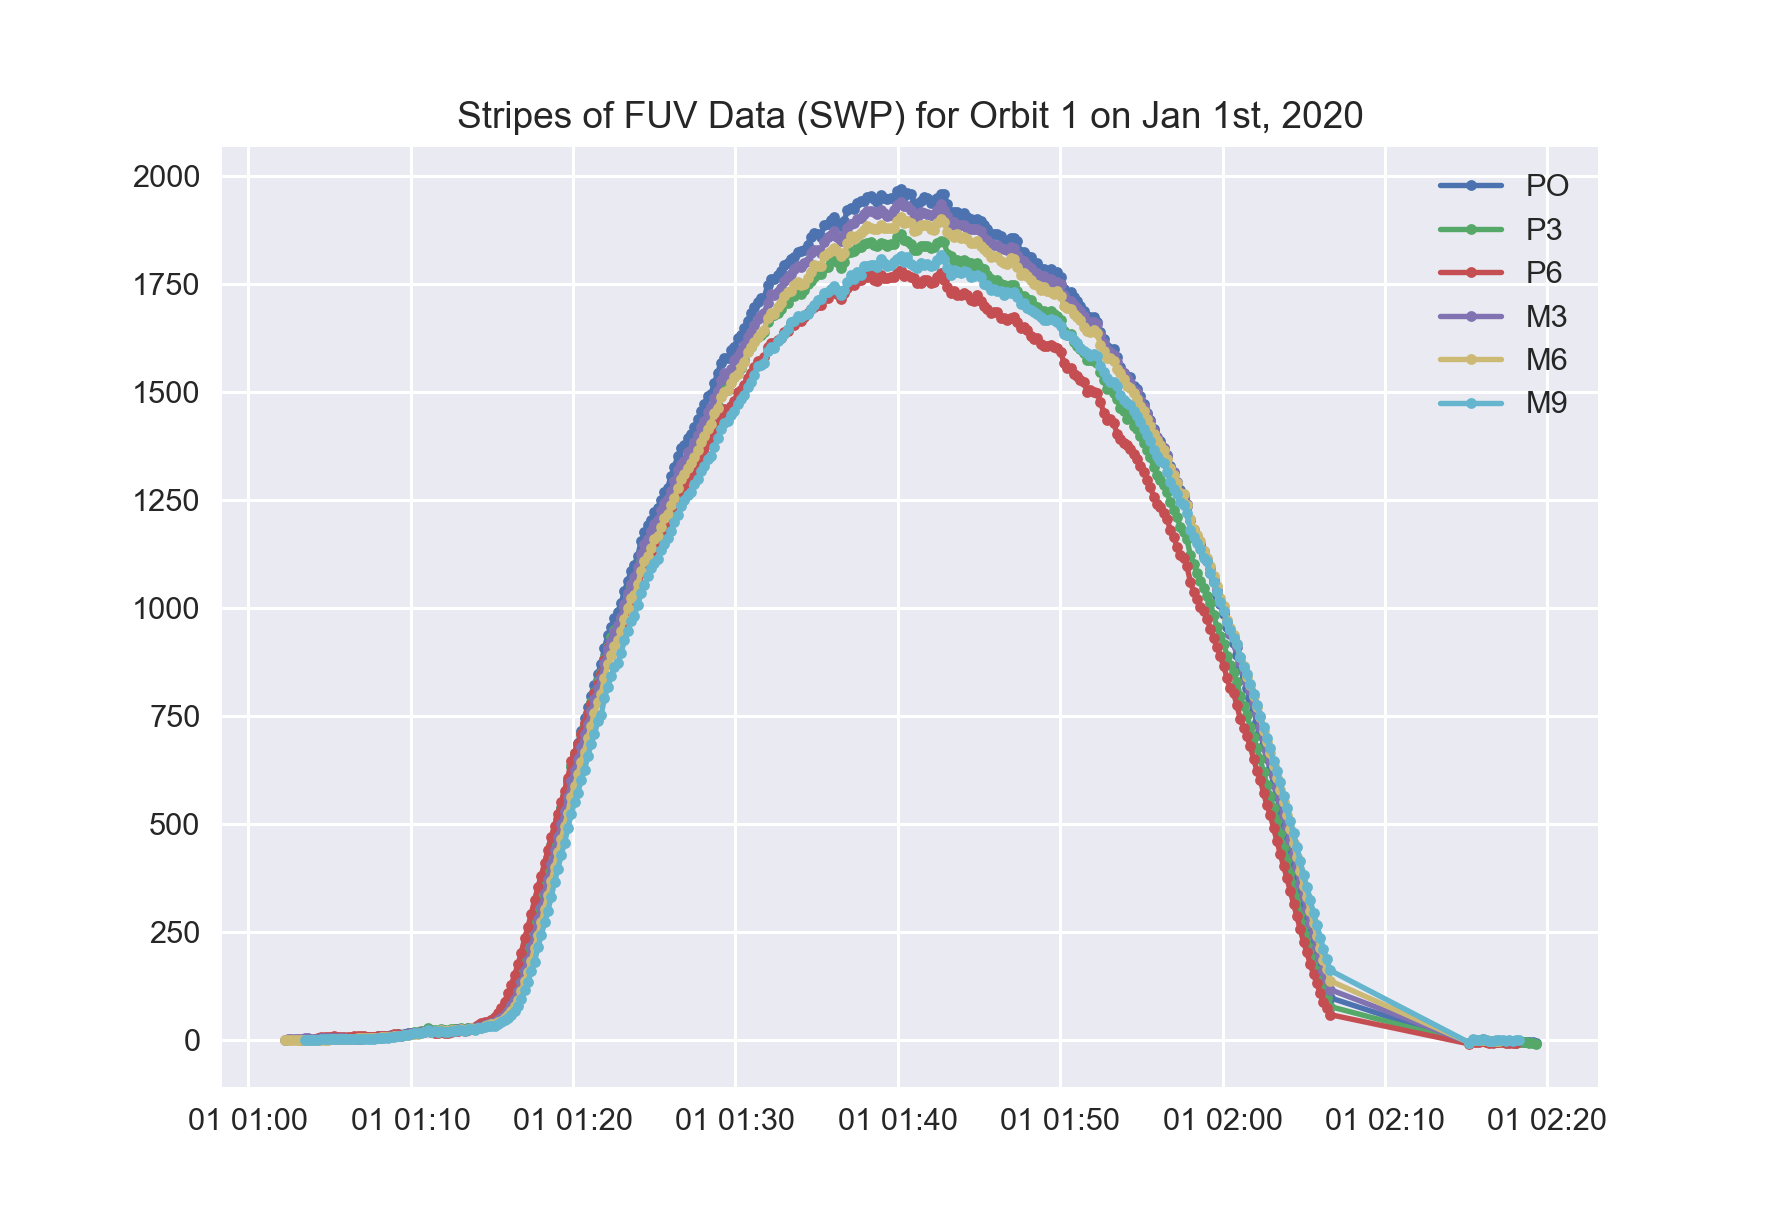

In [26]:
# ALL SWP Plot
swp_p0_all = orbits_finder(swp_p0)
swp_p3_all = orbits_finder(swp_p3)
swp_p6_all = orbits_finder(swp_p6)
swp_m3_all = orbits_finder(swp_m3)
swp_m6_all = orbits_finder(swp_m6)
swp_m9_all = orbits_finder(swp_m9)


plt.figure()
plt.title("Stripes of FUV Data (SWP) for Orbit 1 on Jan 1st, 2020")
plt.plot(single_orb(swp_p0_all,1)[0],single_orb(swp_p0_all,1)[1],marker = '.', label = 'PO')
plt.plot(single_orb(swp_p3_all,1)[0],single_orb(swp_p3_all,1)[1],marker = '.', label = 'P3')
plt.plot(single_orb(swp_p6_all,1)[0],single_orb(swp_p6_all,1)[1],marker = '.', label = 'P6')
plt.plot(single_orb(swp_m3_all,1)[0],single_orb(swp_m3_all,1)[1],marker = '.', label = 'M3')
plt.plot(single_orb(swp_m6_all,1)[0],single_orb(swp_m6_all,1)[1],marker = '.', label = 'M6')
plt.plot(single_orb(swp_m9_all,1)[0],single_orb(swp_m9_all,1)[1],marker = '.', label = 'M9')

plt.legend()
plt.show()


##### LW PEAK FINDER- HAD TO CHANGE THRESHOLDS

In [17]:
def wave_peaks_tdf(df,r):
    df_plt = df.isel(row = r)
    plt.figure()
    plt.title('Data')
    plt.plot(df_plt.time, df_plt.I_1356, 'C3.-') 
    plt.show()
    
    from scipy.signal import find_peaks
    data = df.I_1356.isel(row = r)
    data_np = data.to_numpy()
    np.shape(data)
    
    max_data = max(data_np)
    #time_diff = datetime.timedelta(minutes=19, hours=1) 

    
    indices = find_peaks(data, height = max_data * (4/6), distance = 200) 
    
    indexes = indices[0]
    #print(indexes)
    final_indexes = []
    
    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    print(final_indexes)
    
    times_np = df_plt.time.to_numpy()
    
    times = []
    vals_at_times = []
    for i in final_indexes: 
        times.append(times_np[i])
        vals_at_times.append(data[i])
    #print(times,vals_at_times)
        
    df_plt = df.isel(row = r)
    plt.figure()
    plt.title('Peaks')
    plt.plot(df_plt.time, df_plt.I_1356, 'C3.-') 

    for i in range(0,len(times)):
        plt.plot(times[i],vals_at_times[i],'ro', markersize = 5)
    plt.show()

    

In [18]:
from scipy.signal import find_peaks
def wave_peaks_lw(df, r):
    # Select the specified row from the DataFrame
    df_plt = df.isel(row=r)
    
    # Plot the initial data
    plt.figure()
    plt.title('Data')
    plt.plot(df_plt.time, df_plt.I_1356, 'C3.-') 
    plt.show()
    
    # Extract the data for the specified row
    data = df.I_1356.isel(row=r)
    data_np = data.to_numpy()
    
    # Find peaks in the data
    max_data = np.max(data_np)
    indices = find_peaks(data_np, height= max_data * (1/3), distance = 150) 
    
    # Extract the peak indices
    peak_indices = indices[0]
    final_indices = []
    
    # Filter peaks based on their proximity to each other
    for i in range(len(peak_indices) - 1):
        if len(peak_indices) > 15:
            if peak_indices[i + 1] - peak_indices[i] >= 150:
                final_indices.append(peak_indices[i])
        else:
            final_indices.append(peak_indices[i])
    
    # Append the last peak index
    if len(peak_indices) > 0:
        final_indices.append(peak_indices[-1])
    
    # Convert time data to numpy array for indexing
    times_np = df_plt.time.to_numpy()
    
    # Collect times and values at the peak indices
    times = [times_np[i] for i in final_indices]
    vals_at_times = [data_np[i] for i in final_indices]
    
    # Plot the data with the peaks highlighted
    plt.figure()
    plt.title('Peaks')
    plt.plot(df_plt.time, df_plt.I_1356, 'C3.-') 

    for t, v in zip(times, vals_at_times):
        plt.plot(t, v, 'ro', markersize=5)
    
    plt.show()

In [19]:
def orbits_finder_lw(df):
    #r = 148
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data,max_data * (1/3), distance = 150) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 150:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

<IPython.core.display.Javascript object>


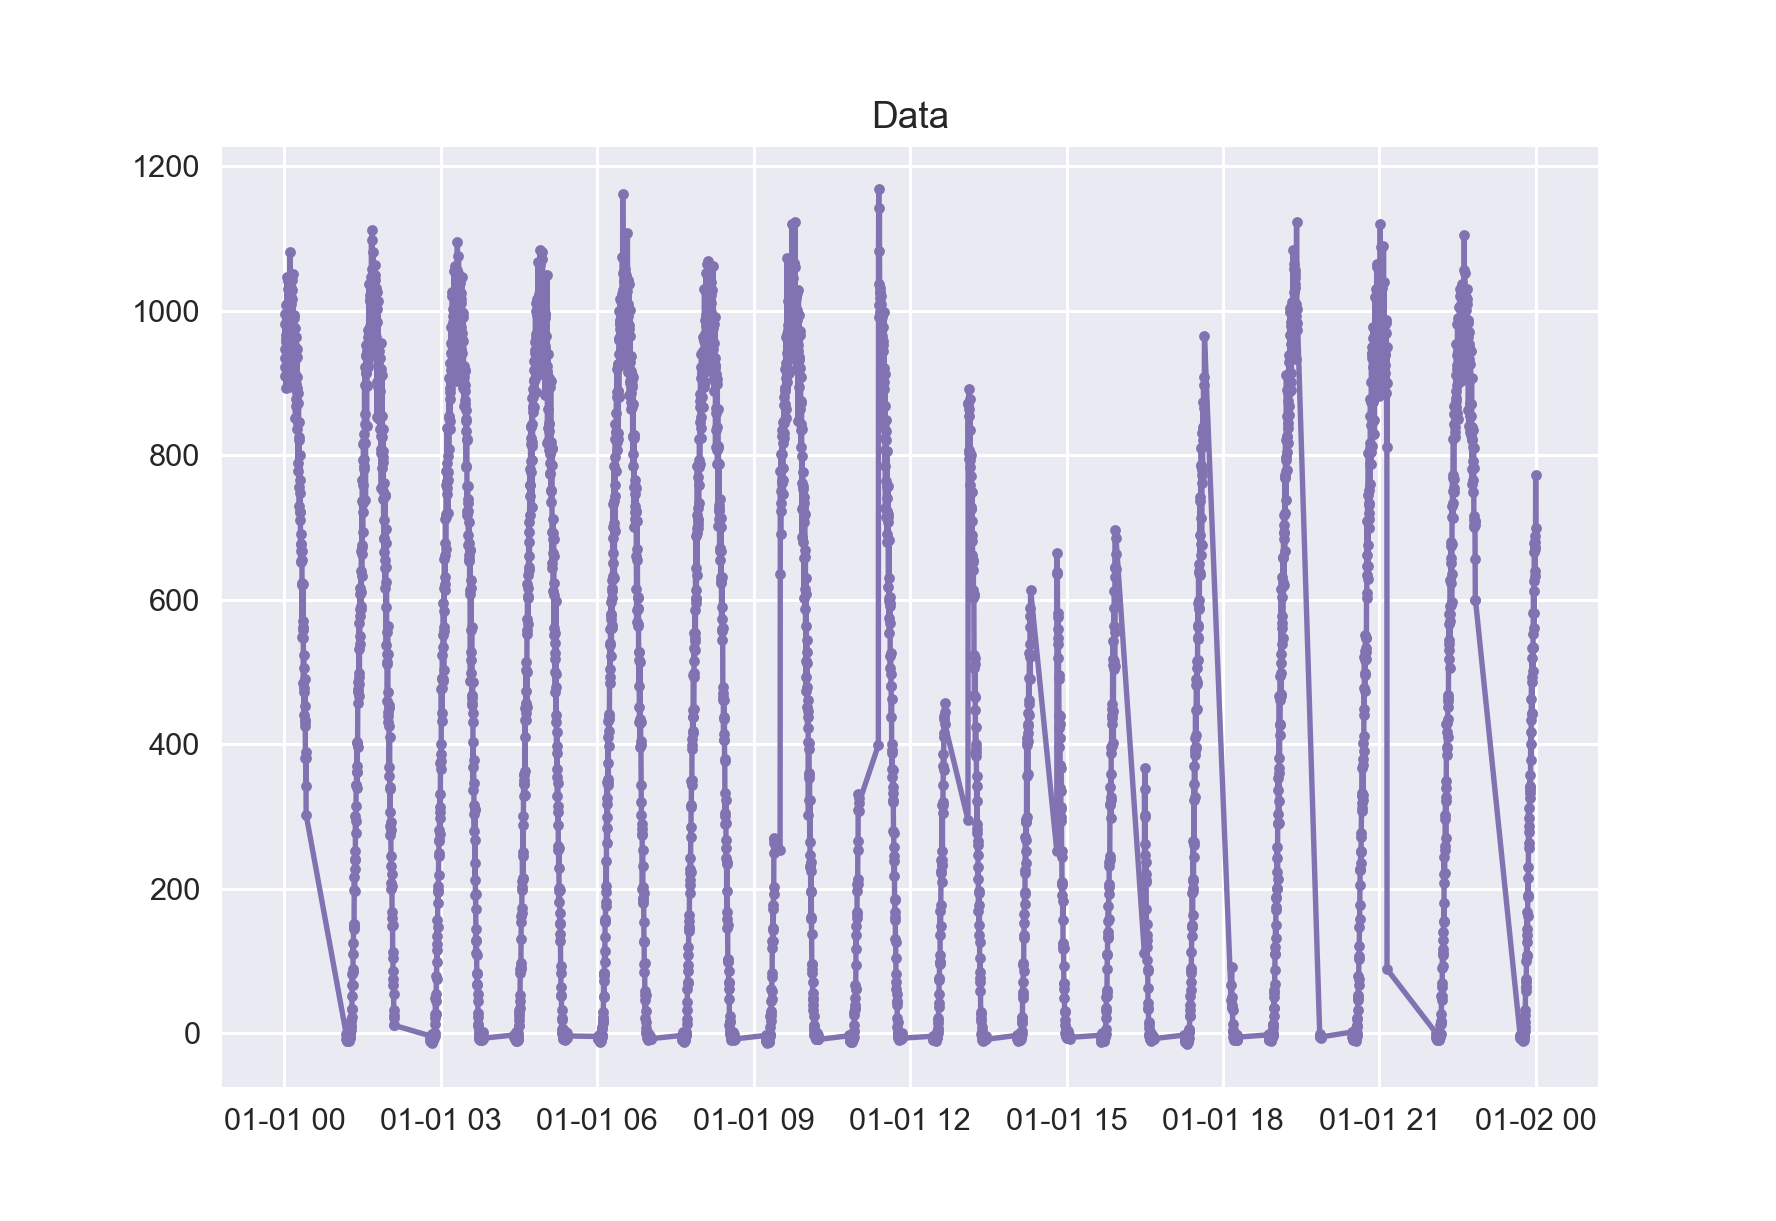

<IPython.core.display.Javascript object>


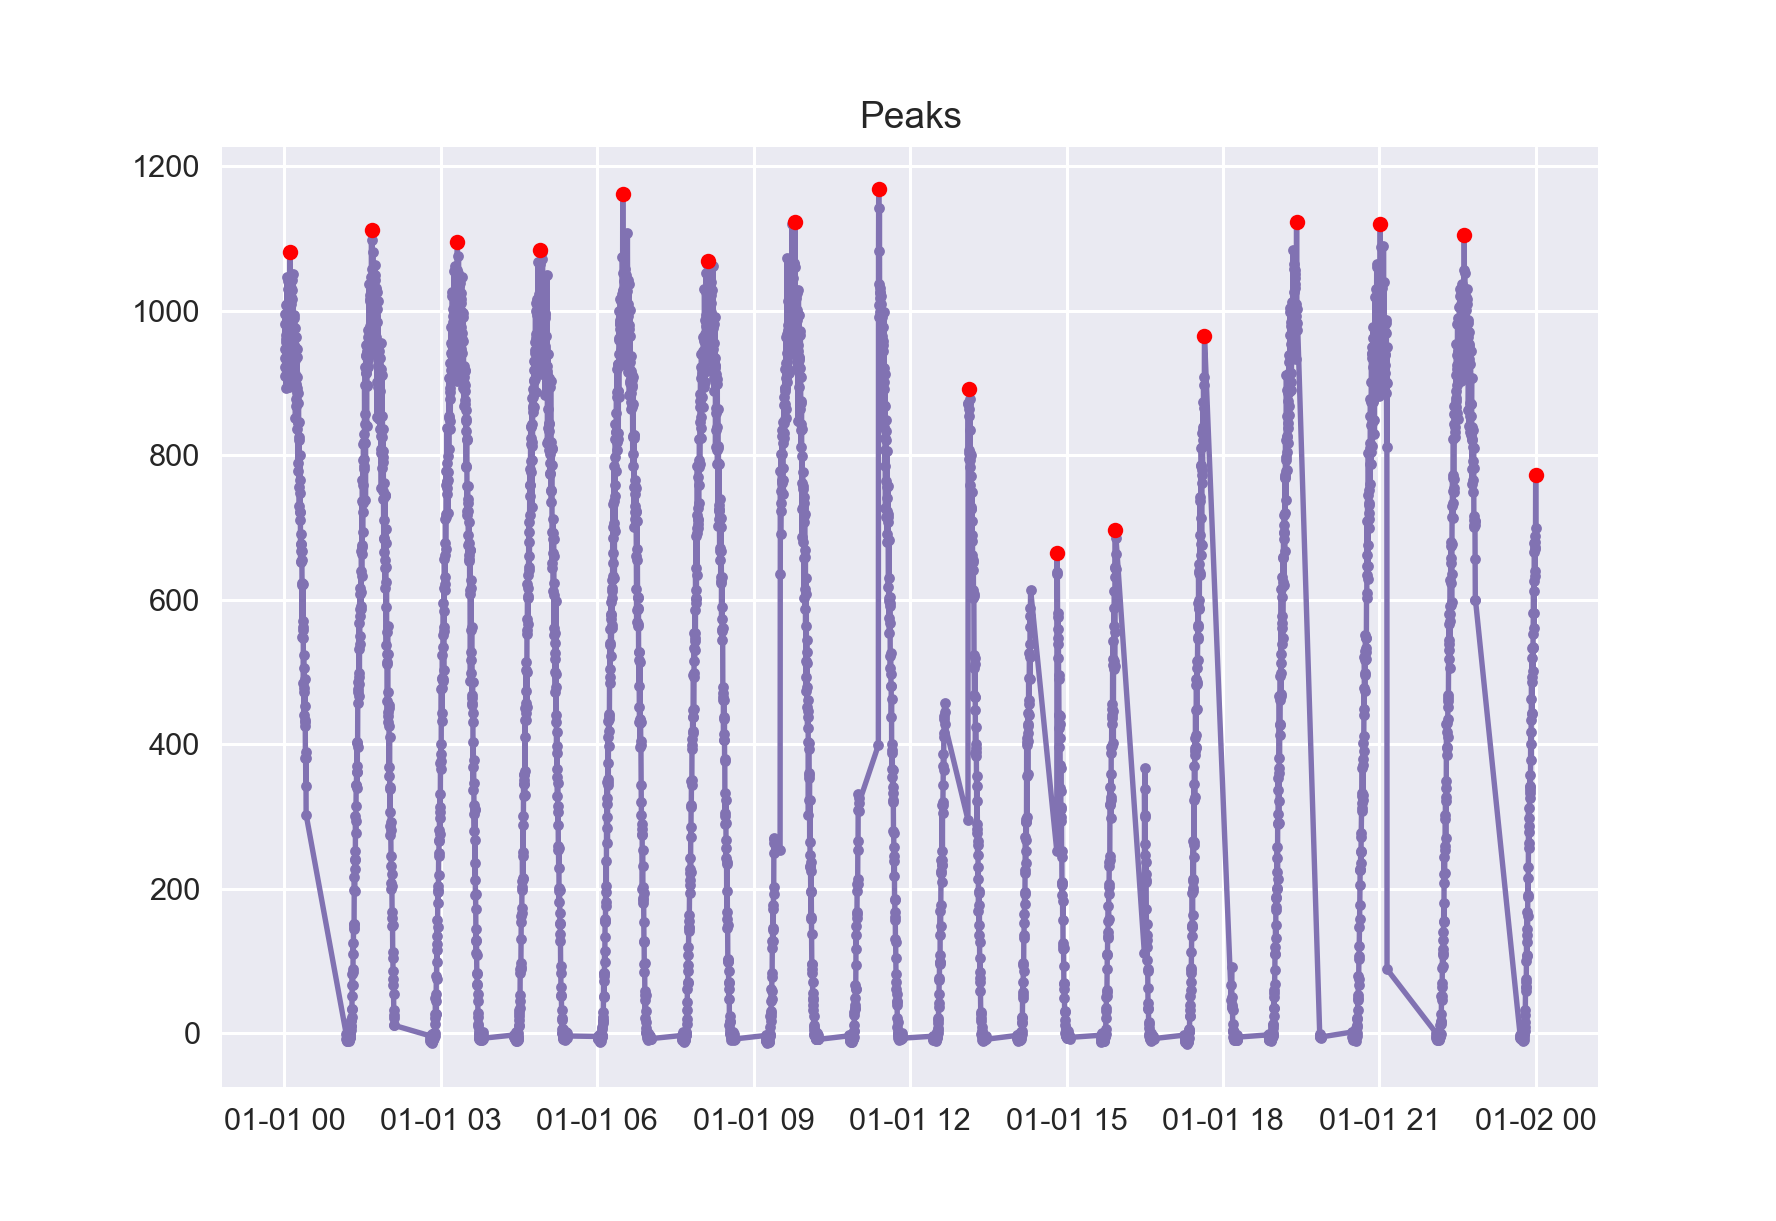

In [20]:
wave_peaks_lw(lwp_p0,115)

<IPython.core.display.Javascript object>


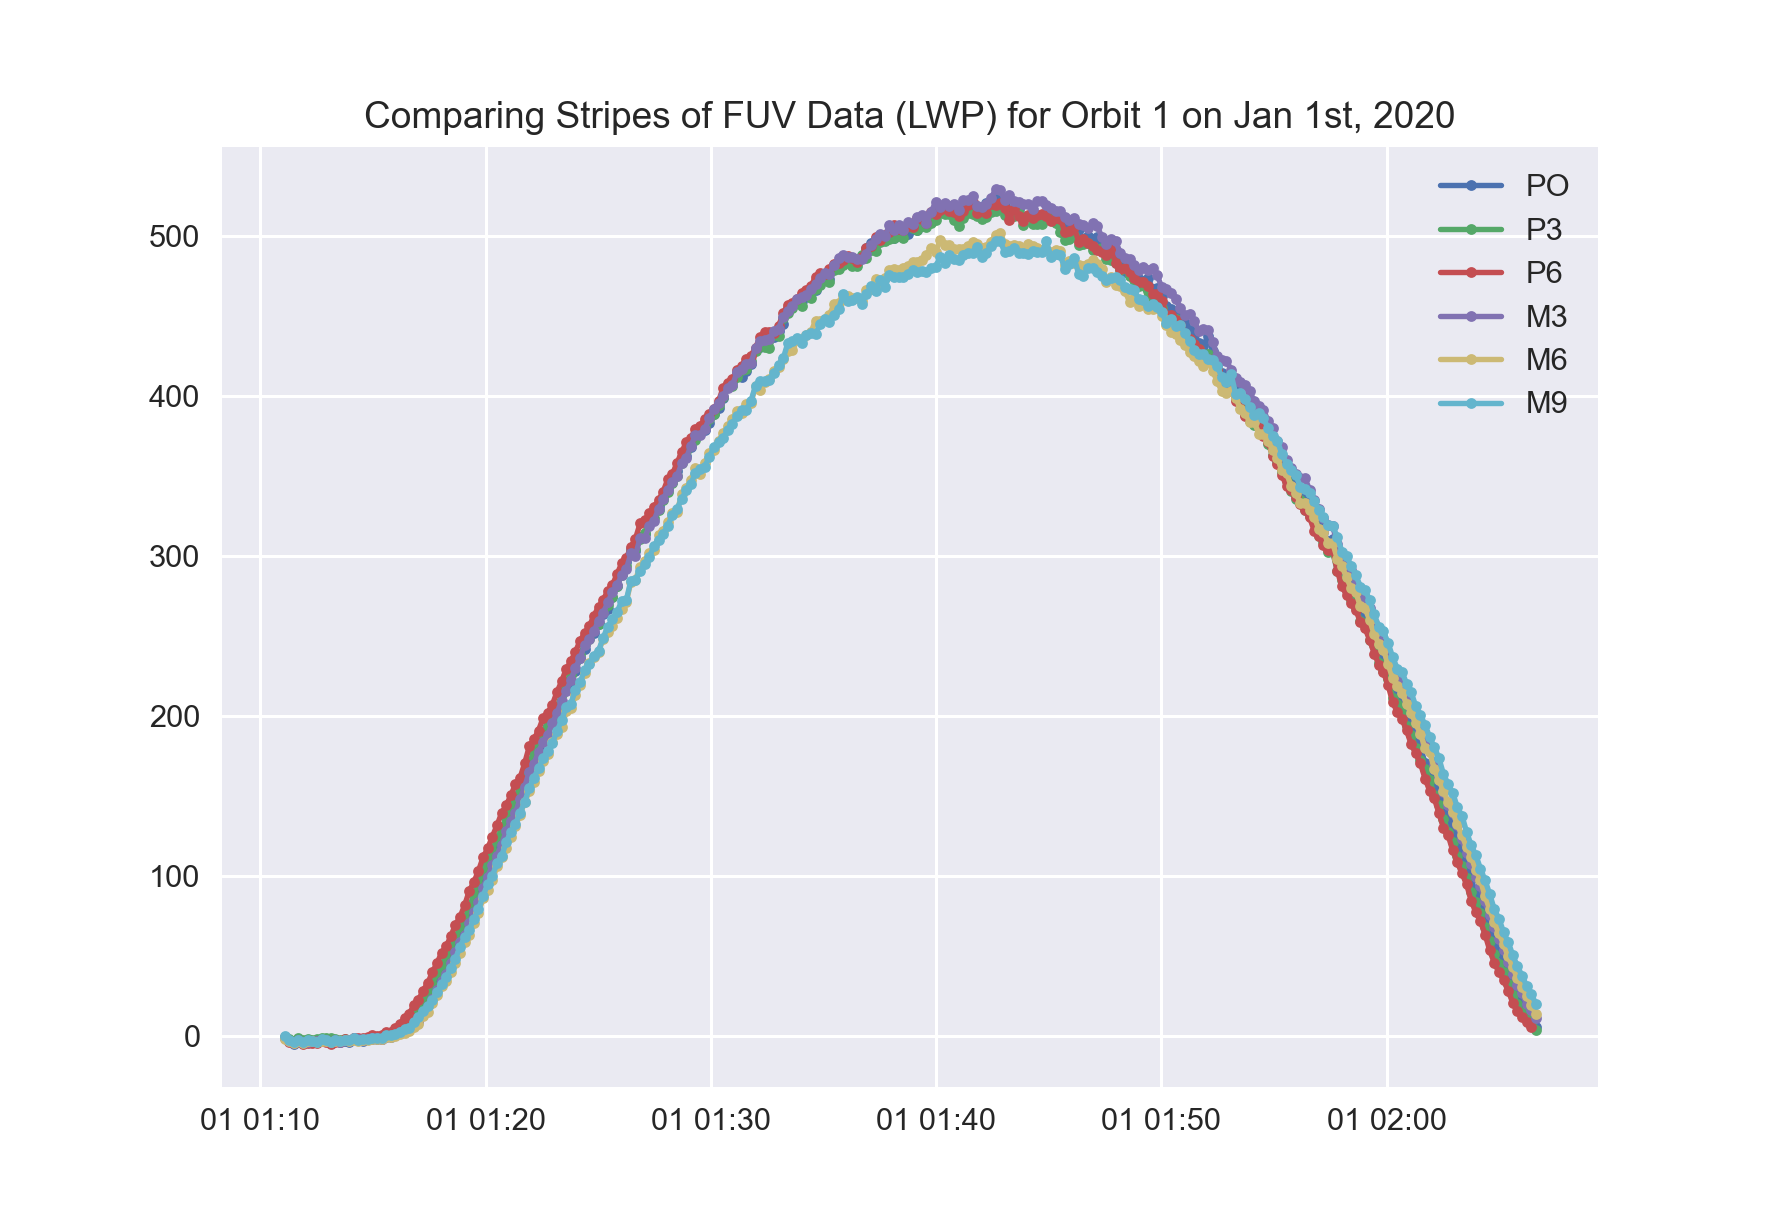

In [27]:
# ALL LWP Plot
lwp_p0_all = orbits_finder_lw(lwp_p0)
lwp_p3_all = orbits_finder_lw(lwp_p3)
lwp_p6_all = orbits_finder_lw(lwp_p6)
lwp_m3_all = orbits_finder_lw(lwp_m3)
lwp_m6_all = orbits_finder_lw(lwp_m6)
lwp_m9_all = orbits_finder_lw(lwp_m9)


plt.figure()
plt.title("Comparing Stripes of FUV Data (LWP) for Orbit 1 on Jan 1st, 2020")
plt.plot(single_orb(lwp_p0_all,1)[0],single_orb(lwp_p0_all,1)[1],marker = '.', label = 'PO')
plt.plot(single_orb(lwp_p3_all,1)[0],single_orb(lwp_p3_all,1)[1],marker = '.', label = 'P3')
plt.plot(single_orb(lwp_p6_all,1)[0],single_orb(lwp_p6_all,1)[1],marker = '.', label = 'P6')
plt.plot(single_orb(lwp_m3_all,1)[0],single_orb(lwp_m3_all,1)[1],marker = '.', label = 'M3')
plt.plot(single_orb(lwp_m6_all,1)[0],single_orb(lwp_m6_all,1)[1],marker = '.', label = 'M6')
plt.plot(single_orb(lwp_m9_all,1)[0],single_orb(lwp_m9_all,1)[1],marker = '.', label = 'M9')

plt.legend()
plt.show()


## SW: 1356 (0)+ a little bit of N2 emission 
## LW: N2

In [28]:
m3_o0 = lwp_m3_all[1]
m3_o0_label = 'M3'
m6_o0 =lwp_m6_all[1]
m6_o0_label = 'M6'
m9_o0 = lwp_m9_all[1]
m9_o0_label = 'M9'


p0_o0 = lwp_p0_all[1]
p0_o0_label = 'P0'
p3_o0 = lwp_p3_all[1]
p3_o0_label = 'P3'
p6_o0 = lwp_p6_all[1]
p6_o0_label = 'P6'

<IPython.core.display.Javascript object>


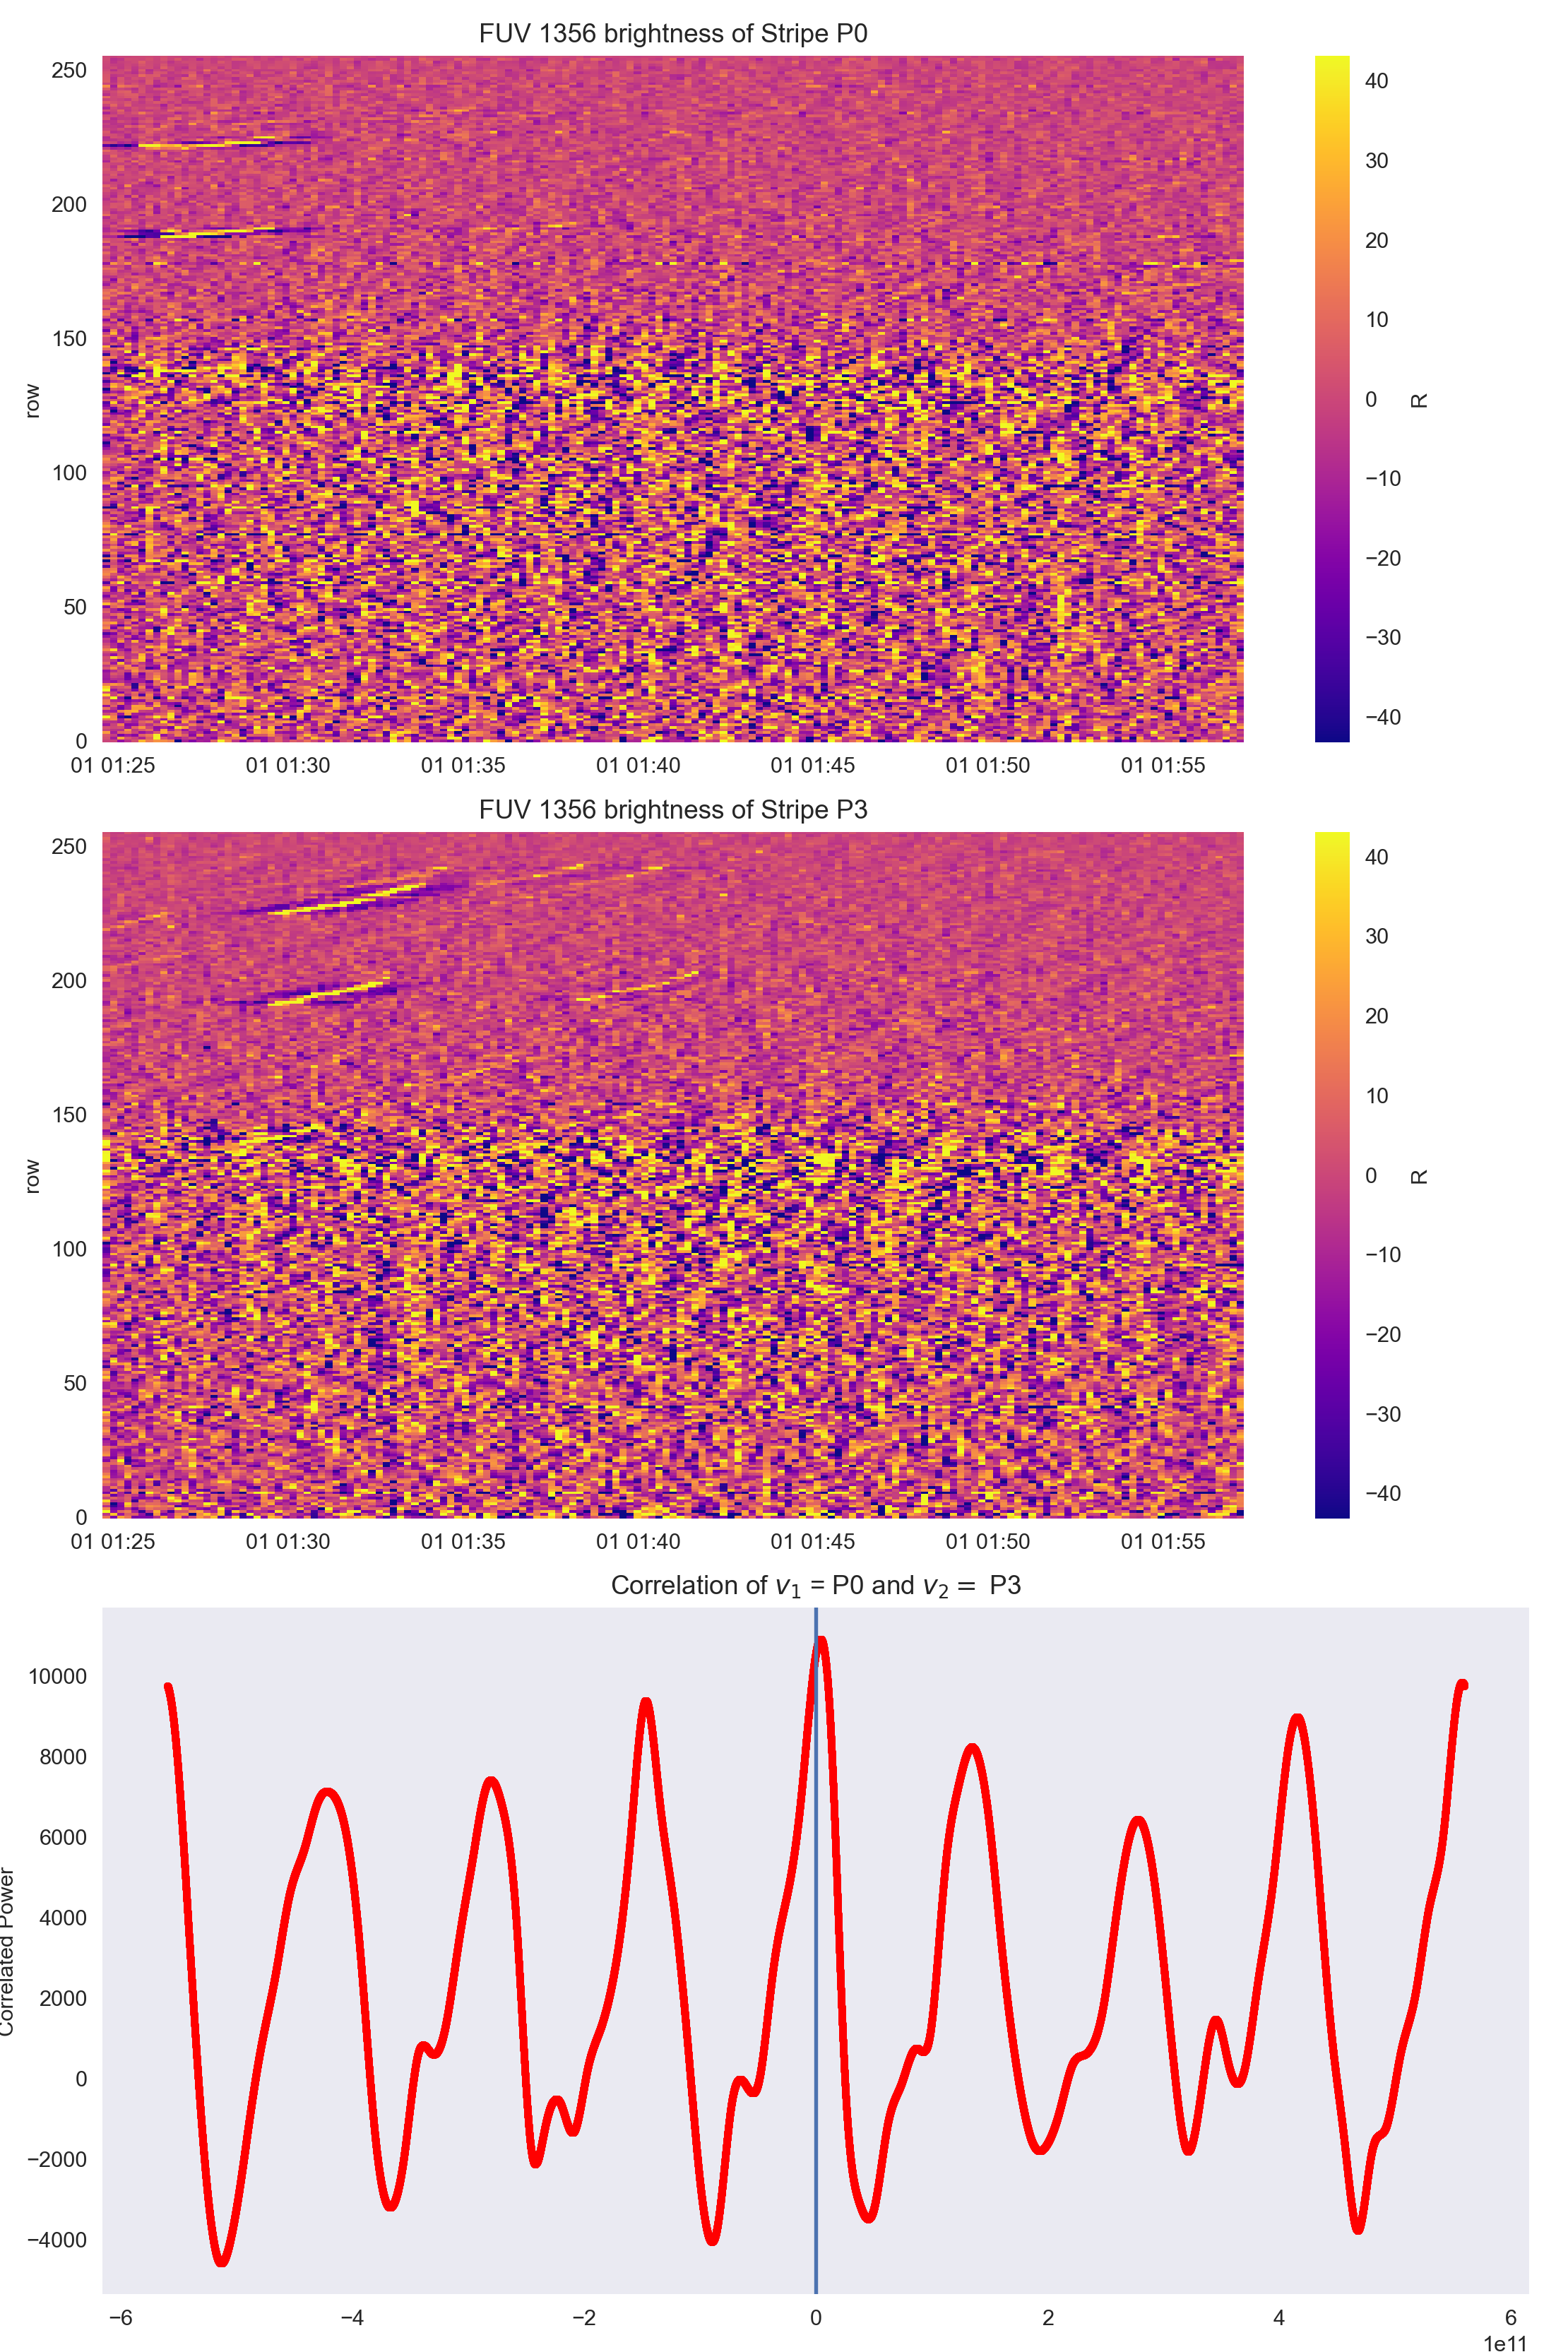

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [29]:
corr_fuvs_and_fuvs(p0_o0,p3_o0,p0_o0_label,p3_o0_label)

<IPython.core.display.Javascript object>


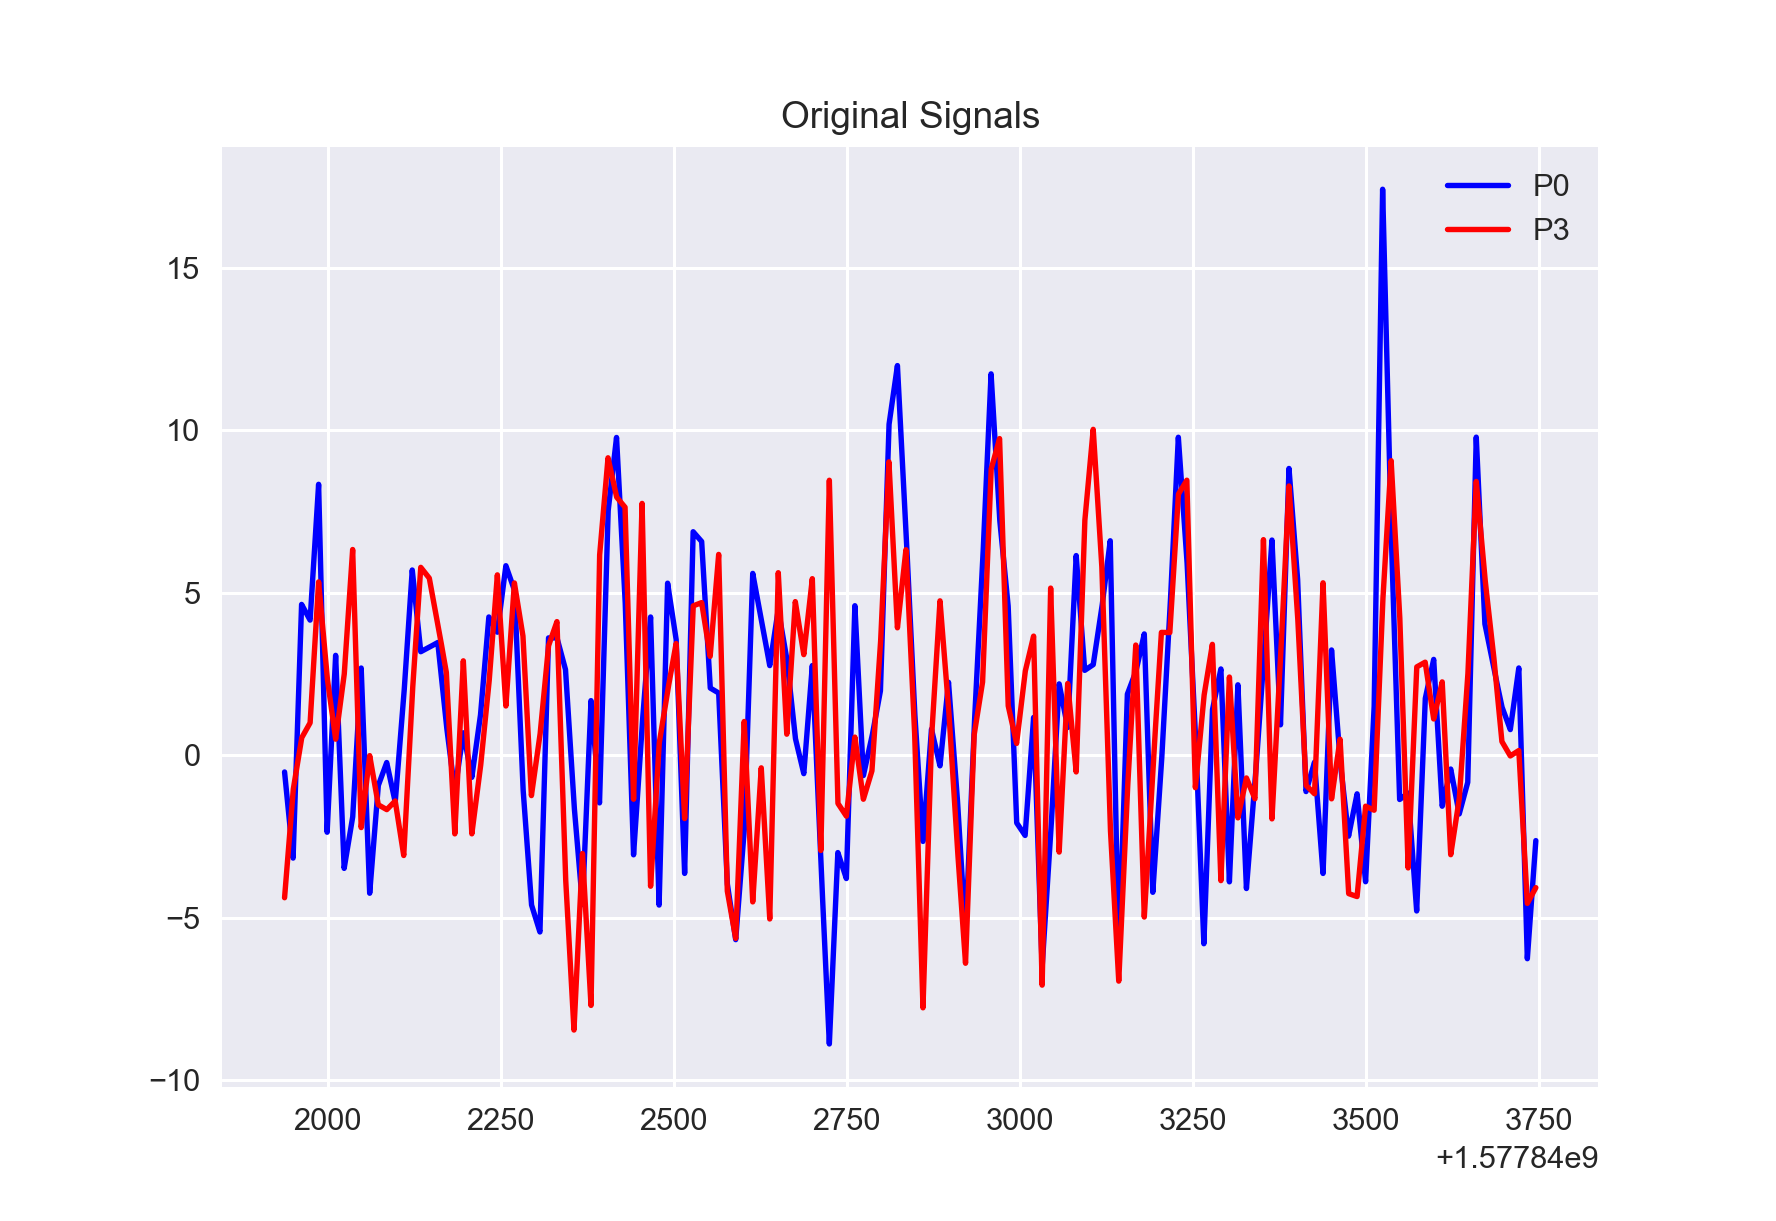

index 74113
xval 1380530943.9999998
Difference from 0: 1.3805309439999998


<IPython.core.display.Javascript object>


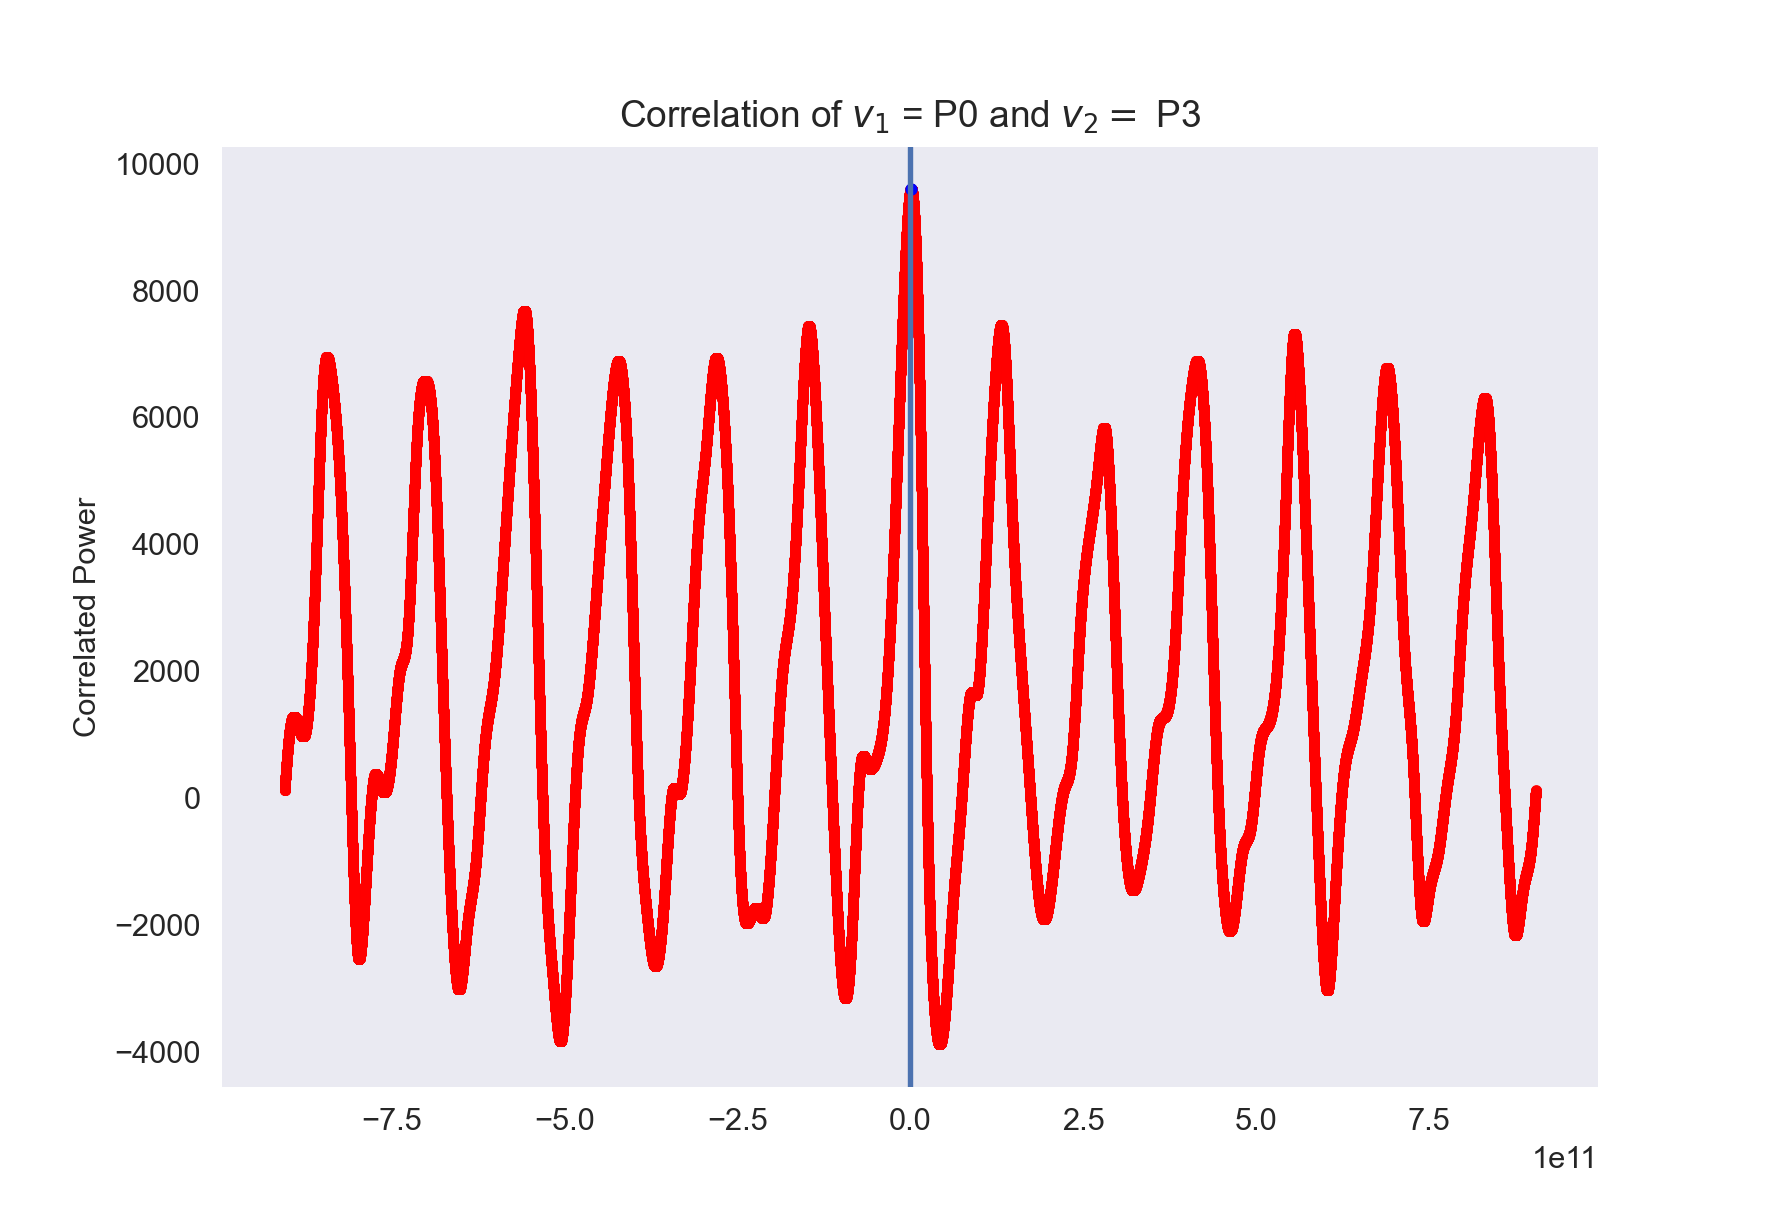

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [30]:
correlations(p0_o0,p3_o0,p0_o0_label,p3_o0_label)

In [37]:
orbs_0 = [m9_o0,m6_o0,m3_o0,p0_o0,p3_o0,p6_o0]
labels_0 = [m9_o0_label,m6_o0_label,m3_o0_label,p0_o0_label,p3_o0_label,p6_o0_label]
angle_diffs_0_df = angle_diff(orbs_0,labels_0)
angle_diffs_0_df

First Second  Difference  First Angle  Second Angle  Angle Diff  \
0     M9     M9    0.000000           -9            -9           0   
1     M9     M6    4.080507           -9            -6           3   
2     M9     M3    6.853786           -9            -3           6   
3     M9     P0    1.722609           -9             0           9   
4     M9     P3    3.420785           -9             3          12   
5     M9     P6    4.410369           -9             6          15   
6     M6     M9   -4.080507           -6            -9          -3   
7     M6     M6    0.000000           -6            -6           0   
8     M6     M3    2.199076           -6            -3           3   
9     M6     P0    2.052471           -6             0           6   
10    M6     P3    0.708591           -6             3           9   
11    M6     P6   -1.527136           -6             6          12   
12    M3     M9   -6.853786           -3            -9          -6   
13    M3     M6   -2.199076           -3            -6          -3   
14    M3     M3    0.000000           -3            -3           0   
15    M3     P0   -0.427598           -3             0           3   
16    M3     P3   -3.457436           -3             3           6   
17    M3     P6   -0.867413           -3             6           9   
18    P0     M9   -1.722609            0            -9          -9   
19    P0     M6   -2.052471            0            -6          -6   
20    P0     M3    0.427598            0            -3          -3   
21    P0     P0    0.000000            0             0           0   
22    P0     P3    1.380531            0             3           3   
23    P0     P6   -0.097737            0             6           6   
24    P3     M9   -3.420785            3            -9         -12   
25    P3     M6   -0.708591            3            -6          -9   
26    P3     M3    3.457436            3            -3          -6   
27    P3     P0   -1.380531            3             0          -3   
28    P3     P3    0.000000            3             3           0   
29    P3     P6   -0.244342            3             6           3   
30    P6     M9   -4.410369            6            -9         -15   
31    P6     M6    1.527136            6            -6         -12   
32    P6     M3    0.867413            6            -3          -9   
33    P6     P0    0.097737            6             0          -6   
34    P6     P3    0.244342            6             3          -3   
35    P6     P6    0.000000            6             6           0   

    Absolute Time Difference  
0                   0.000000  
1                   4.080507  
2                   6.853786  
3                   1.722609  
4                   3.420785  
5                   4.410369  
6                   4.080507  
7                   0.000000  
8                   2.199076  
9                   2.052471  
10                  0.708591  
11                  1.527136  
12                  6.853786  
13                  2.199076  
14                  0.000000  
15                  0.427598  
16                  3.457436  
17                  0.867413  
18                  1.722609  
19                  2.052471  
20                  0.427598  
21                  0.000000  
22                  1.380531  
23                  0.097737  
24                  3.420785  
25                  0.708591  
26                  3.457436  
27                  1.380531  
28                  0.000000  
29                  0.244342  
30                  4.410369  
31                  1.527136  
32                  0.867413  
33                  0.097737  
34                  0.244342  
35                  0.000000

<IPython.core.display.Javascript object>


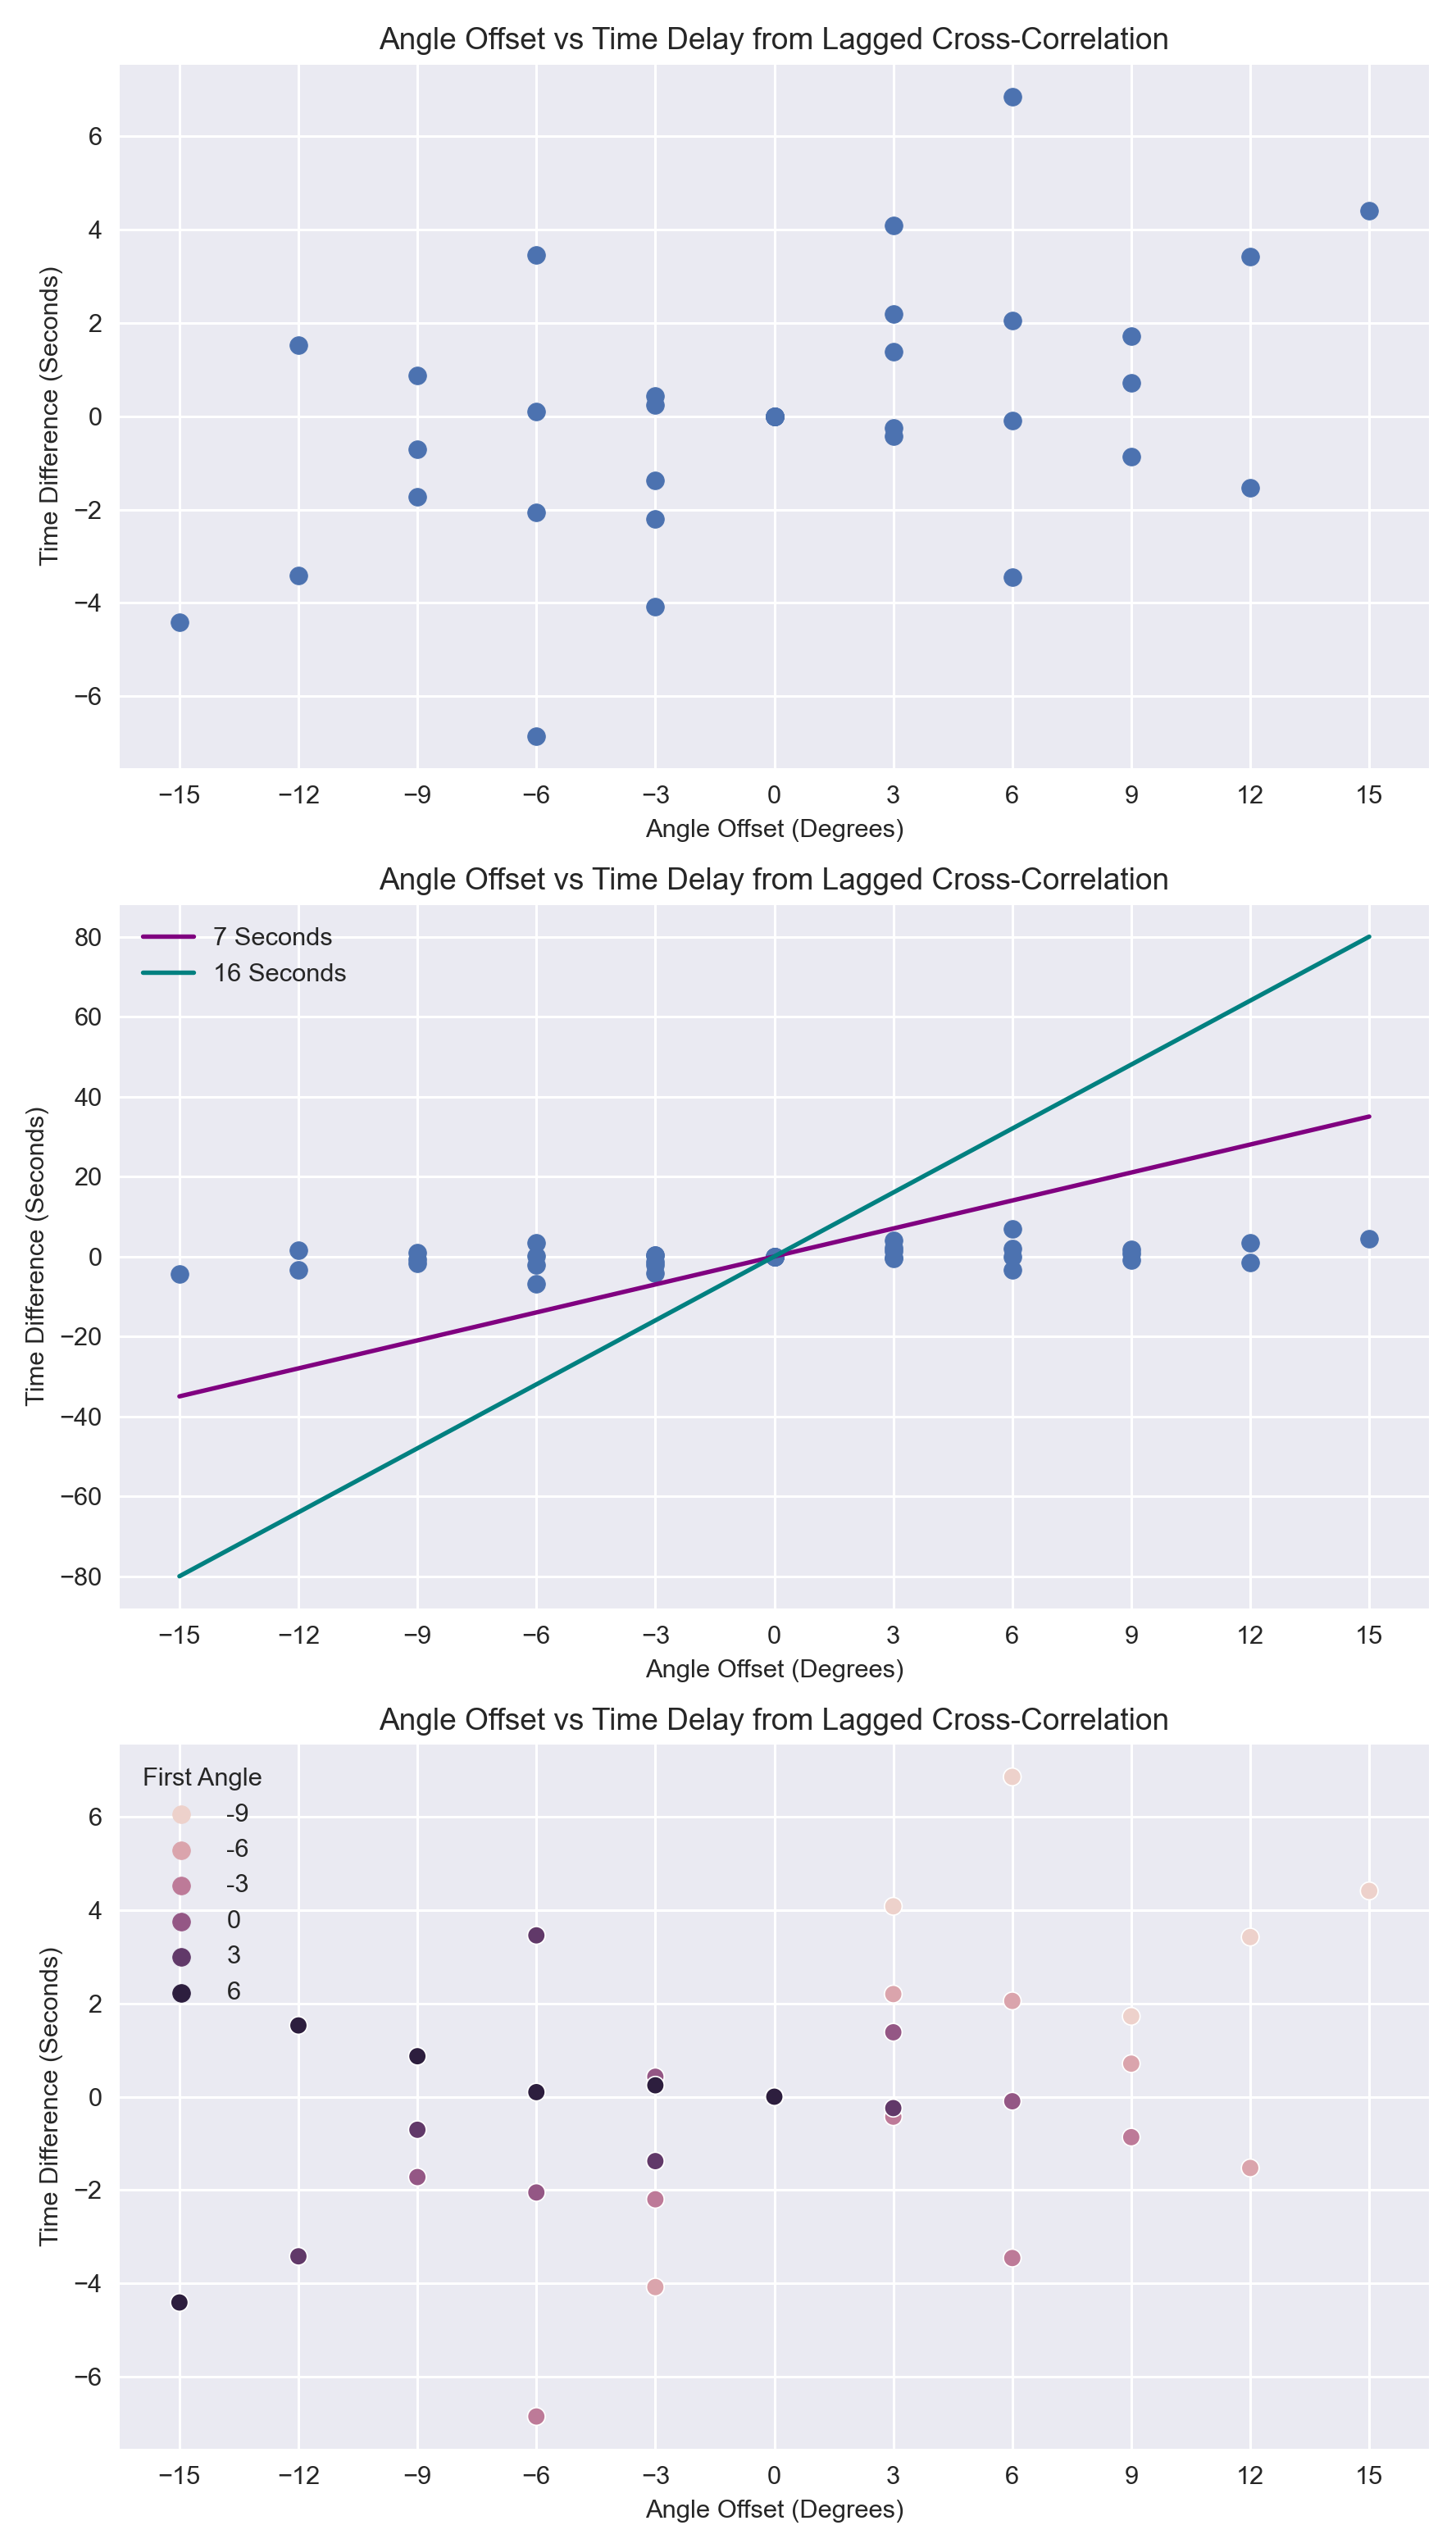

In [38]:
offset_plots(angle_diffs_0_df)

In [43]:
L1f_swp_01 = 'ICON_L1_FUV_SWP_2020-01-01_v05r000.NC'
L1f_lwp_01 = 'ICON_L1_FUV_LWP_2020-01-01_v05r000.NC'